<center><h1>1-e: Transformers</h1></center>


Students:
- **BOURZAG MOHAMED CHAKIB**
- **MISSOUM YOUCEF**

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>


# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.

In this notebook, we will implement the first Visual Transformer, [ViT](https://arxiv.org/abs/2010.11929). We'll implement a naive version of it, much smaller than the ones described in the paper, and we also won't use complex data augmentation and regularizations. But note that this is important to make transformers work in practice on large-scale dataset.

To get a gist of what is required to make a transformer work in practice, have a look at the [DeiT and CaiT codebase](https://github.com/facebookresearch/deit).

This notebook is a simplified version of the excellent [Timm library](https://github.com/rwightman/pytorch-image-models).

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
import matplotlib.pyplot as plt
from PIL import Image

Let's load the MNIST dataset:

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 499kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.0MB/s]


... and visualize!

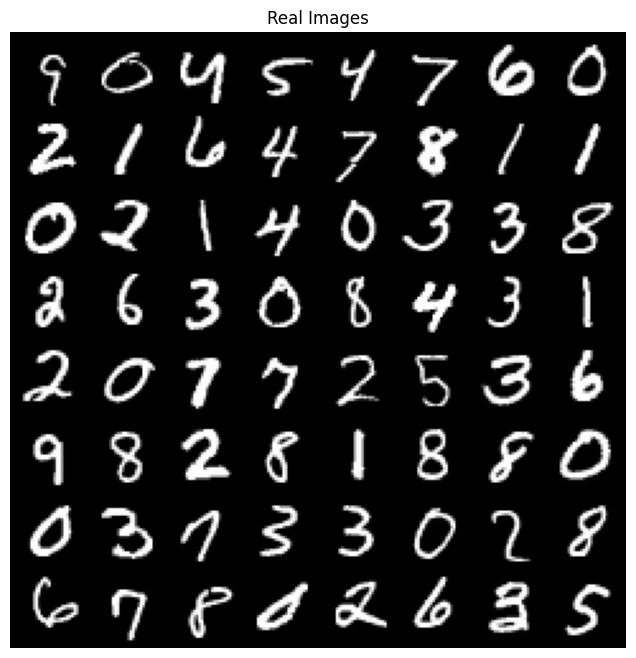

In [ ]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

# Here is the general architecture of the ViT model
## The architecture includes:
- A step for splitting the image into disjoint patches with a linear projection of the patches
- Positional encoding to capture the absolute spatial information of each patch in the image
- The addition of a "[CLS]" token, initialized randomly and learned during training
- A transformer encoder that learns the representation of each token
- A classification head that performs class prediction from the re-embedded [CLS] token at the output of the encoder

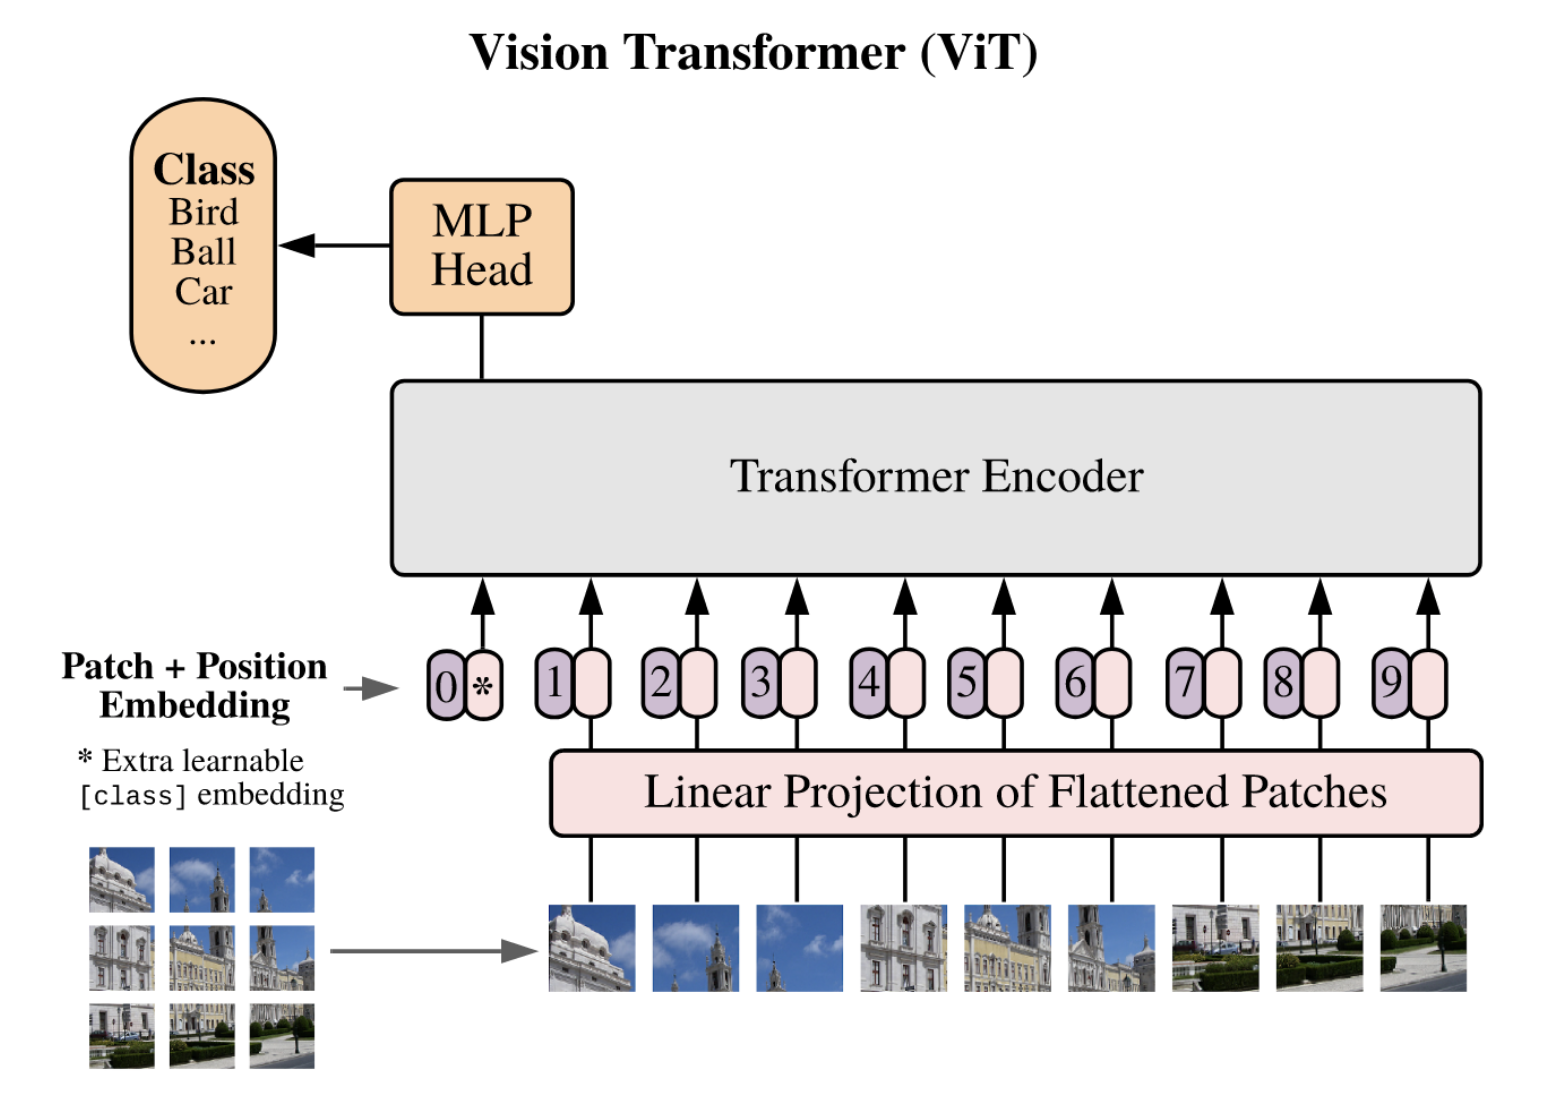

# Linear Projection of flattened patches

**Q1**:
First, we need to code the patch embedding. In NLP, it could be using a word2vec embeddings, but we need something different in Computer Vision.

You are going to use a specific 2d convolution to play the role of the so-called "Linear Projection" on the image above and process each patch independently without overlap. Think a bit how you could do that.

Then, you need to manipulate the dimensions of the resulting tensor to get a final tensor of shape `(batch_size, nb_tokens, embedding_dim)`. *Hint: You will need a `view/reshape` and `transpose/permute` operators*.

As usual, remember to check the output shape of your layer by trying with a random tensor!

In [ ]:
class PatchEmbed(nn.Module):
  def __init__(self, in_chan=1, patch_size=7, embed_dim=128):
    super().__init__()
    ## TODO
    self.projection = nn.Conv2d(in_channels=in_chan, out_channels=embed_dim, kernel_size=patch_size, padding=0, stride=patch_size)    # Moving by patch_size prevents overlapping

  def forward(self, x):
    x = self.projection(x)

    B, C, H, W = x.shape    # (B, embedding_size, H/P, W/P)
    # print(x.shape)
    ## TODO
    x = x.reshape(B, C, H*W)     # (B, embedding_size, H*W/P² = nb_tokens)
    # x = x.flatten(2)

    # x.shape() -> B, N, C
    # x = x.transpose(1, 2)
    x = x.permute(0, 2, 1)      # (B, nb_tokens, embedding_size)
    return x

In [ ]:
x = torch.randn(8, 3, 32, 32)  # batch_size=8, RGB 32x32
patch_embed = PatchEmbed(in_chan=3, patch_size=4, embed_dim=50)
out = patch_embed(x)

print(out.shape)

torch.Size([8, 50, 8, 8])
torch.Size([8, 64, 50])


# Transformer encoder

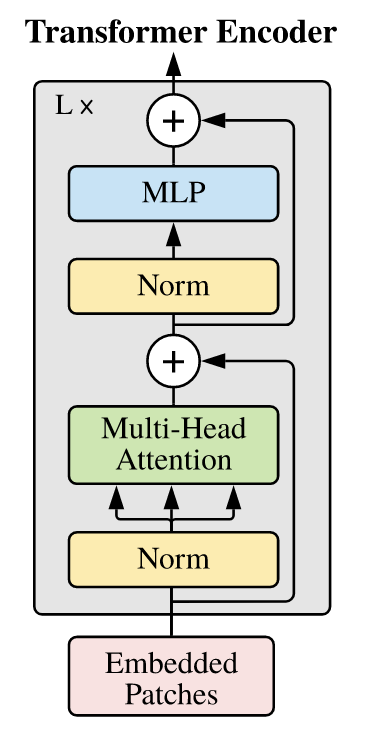

## Q2: MLP

Now we need to build a transformer block. Let's first build the easiest part, the MLP! By now, you should be confident how to code one.

Code a MLP with one hidden layer. Note that the input and output dimensions will be the same. Instead of ReLU, use the activation GELU, which is a slight alternative often used for transformers.

In [ ]:
class MLP(nn.Module):
  def __init__(self, in_features, hid_features):
    super().__init__()

    # TODO
    self.fc1 = nn.Linear(in_features, hid_features)
    self.fc2 = nn.Linear(hid_features, in_features)
    self.gelu = nn.GELU()

  def forward(self, x):
    # TODO
    x = self.fc1(x)
    x = self.gelu(x)
    x = self.fc2(x)
    return x


MLP(128, 512)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

## Q3: Self-attention

Now we are going to build the famous **Self-Attention**.
- What is the main feature of self-attention, especially compared to its convolutional counterpart. What is its main challenge in terms of computation/memory?
  - The main feature of self-attention is that each token (or patch) in the input can attend to every other token — meaning it can gather **global** context from the entire image or sequence. In contrast:
      - A convolution only captures local information through a small receptive field (e.g., a 3×3 kernel).

      - Self-attention captures long-range dependencies because it directly relates every token to all others.

  - The main challenge of self-attention lies in its **computational** and **memory** complexity, which scales quadratically with the number of tokens 𝑁.
      
- At first, we are going to only consider the simple case of one head. Write the equations and complete the following code. And don't forget a final linear projection at the end!

### 🧠 Self-Attention (Single Head)

Given an input:
$
X \in \mathbb{R}^{N \times d}
$

We compute the **queries (Q)**, **keys (K)**, and **values (V)** as linear projections:

$
Q = X W_Q, \quad K = X W_K, \quad V = X W_V
$

where:
$
W_Q, W_K, W_V \in \mathbb{R}^{d \times d_k}
$

---

#### **1️. Compute attention scores:**
$
\text{Scores} = \frac{Q K^T}{\sqrt{d_k}}
$

---

#### **2️. Normalize with softmax:**
$
A = \text{Softmax}(\text{Scores})
$

---

#### **3️. Weighted sum of values:**
$
Z = A V
$

---

#### **4️. Final linear projection:**
$
\text{Output} = Z W_O
$

where:
$
W_O \in \mathbb{R}^{d_k \times d}
$

---

#### **- Complexity:**
$
\text{Time and memory cost} = \mathcal{O}(N^2 \cdot d)
$

This quadratic complexity is the main computational challenge of self-attention compared to convolutions.

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, embed_dim):
    super().__init__()

    # TODO
    self.d_model = embed_dim
    self.d_k = embed_dim
    self.W_q = nn.Linear(embed_dim, embed_dim)
    self.W_k = nn.Linear(embed_dim, embed_dim)
    self.W_v = nn.Linear(embed_dim, embed_dim)
    self.W_0 = nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
    B, N, C = x.shape

    # TODO: compute the Q, K, V
    q = self.W_q(x)     # (B, N, embed_dim)
    k = self.W_k(x)     # (B, N, embed_dim)
    v = self.W_v(x)     # (B, N, embed_dim)

    # TODO: compute the attention matrix using Q and K
    attention = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
    print("Q * K_t shape: ", attention.shape)      # (B, N, N)

    # TODO: compute the final version using the attention,
    # V, and the final projection
    attention_scores = torch.softmax(attention, dim=-1)
    print("softmax(Q * K_t) shape: ", attention_scores.shape)   # (B, N, N)

    full_attention = torch.matmul(attention_scores, v)
    print("Attention shape: ",full_attention.shape)     # (B, N, embed_dim)
    x = self.W_0(full_attention)      # (B, N, embed_dim)

    return x


SelfAttention(128)(torch.randn(32, 16, 128)).shape

Q * K_t shape:  torch.Size([32, 16, 16])
softmax(Q * K_t) shape:  torch.Size([32, 16, 16])
Attention shape:  torch.Size([32, 16, 128])


torch.Size([32, 16, 128])

# Q4 : Multi-head self-attention

Now we need to build a Multi-Heads Self-Attention.
- Write the equations and complete the following code to build a Multi-Heads Self-Attention.
- The total embedding size will be shared equally among all heads.


### **Multi-Head Self-Attention**

Given an input:
$
X \in \mathbb{R}^{N \times d}
$

For **H heads**, we project X into separate queries, keys, and values for each head \(h = 1, \dots, H\):

$
Q_h = X W_Q^h, \quad K_h = X W_K^h, \quad V_h = X W_V^h
$

where each:
$
W_Q^h, W_K^h, W_V^h \in \mathbb{R}^{d \times d_k}, \quad d_k = \frac{d}{H}
$

---

#### **1️. Compute attention for each head:**
$
\text{Scores}_h = \frac{Q_h K_h^T}{\sqrt{d_k}}, \quad
A_h = \text{Softmax}(\text{Scores}_h), \quad
Z_h = A_h V_h
$

---

#### **2️. Concatenate all heads:**
$
Z = \text{Concat}(Z_1, Z_2, \dots, Z_H) \in \mathbb{R}^{N \times d}
$

---

#### **3️. Final linear projection:**
$
\text{Output} = Z W_O, \quad W_O \in \mathbb{R}^{d \times d}
$

---

#### **- Complexity:**
$
\text{Time and memory cost} = \mathcal{O}(H \cdot N^2 \cdot d_k) = \mathcal{O}(N^2 \cdot d)
$

> Multi-head attention allows the model to attend to different subspaces of features in parallel, improving expressivity.


In [ ]:
class MultiHeadsSelfAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()

    assert embed_dim % num_heads == 0, "d_model must be divisible by num_heads"

    self.head_dim = embed_dim // num_heads
    self.scale = self.head_dim ** -0.5
    self.num_heads = num_heads

    self.q = nn.Linear(embed_dim, embed_dim)
    self.k = nn.Linear(embed_dim, embed_dim)
    self.v = nn.Linear(embed_dim, embed_dim)
    self.projection = nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
    B, N, C = x.shape
    # print("B = ", B)
    # print("N = ", N)
    # print("d_model = ", C)

    q = self.q(x)     # (B, N, embed_dim)
    k = self.k(x)     # (B, N, embed_dim)
    v = self.v(x)     # (B, N, embed_dim)

    # You need to reshape and permute dimension in a certain manner
    # so that each head (C // num_heads) interact
    # only with its dimensions and not other heads.
    q = q.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)         # (B, N, H, embed_dim // H) -> (B, H, N, embed_dim // H)    to calculate attention among each head separately
    k = k.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)
    v = v.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)

    # Try to write at each operation the shape of the tensor if you
    # feel confused.
    attention = torch.matmul(q, k.transpose(-2, -1)) * self.scale
    # print("Q * K_t shape: ", attention.shape)      # (B, H, N, N)

    attention_scores = torch.softmax(attention, dim=-1)
    # print("softmax(Q * K_t) shape: ", attention_scores.shape)   # (B, H, N, N)

    full_attention = torch.matmul(attention_scores, v)
    # print("Attention shape: ", full_attention.shape)        # (B, H, N, embed_dim // H)

    concat_attentions = full_attention.transpose(1, 2).reshape(B, N, C)
    # print("Concatenated attentions shape: ", concat_attentions.shape)     # (B, N, H, embed_dim // H) -> (B, N, embed_dim)

    # TODO

    x = self.projection(concat_attentions)      # (B, N, embed_dim)

    return x


MultiHeadsSelfAttention(embed_dim=50, num_heads=2)(out).shape

torch.Size([8, 64, 50])

# Q5: Transfomer block

Now, we need to build a Transformer **Block** as described in the image below.
- Write the equations and complete the following code.
- For the Layer Normalization, use PyTorch LayerNorm: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

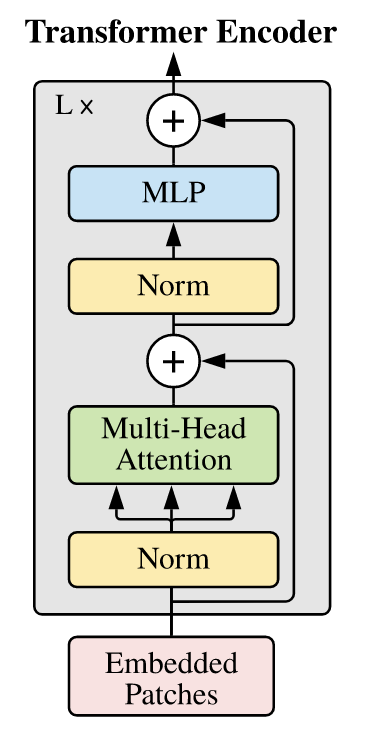

In [ ]:
class Block(nn.Module):
  def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
    super().__init__()

    # TODO
    self.self_attention = MultiHeadsSelfAttention(embed_dim=embed_dim, num_heads=num_heads)
    self.layer_norm1 = nn.LayerNorm(embed_dim)
    self.layer_norm2 = nn.LayerNorm(embed_dim)
    self.mlp = MLP(in_features=embed_dim, hid_features=embed_dim * mlp_ratio)

  def forward(self, x):
    # TODO
    x = x + self.self_attention(self.layer_norm1(x))
    x = x + self.mlp(self.layer_norm2(x))
    return x

Block(128)(torch.randn(32, 16, 128)).shape

B =  32
N =  16
d_model =  128
Q * K_t shape:  torch.Size([32, 4, 16, 16])
softmax(Q * K_t) shape:  torch.Size([32, 4, 16, 16])
Attention shape:  torch.Size([32, 4, 16, 32])
Concatenated attentions shape:  torch.Size([32, 16, 128])


torch.Size([32, 16, 128])

# Q6: Full ViT model

Now you need to build a ViT model based on what you coded in the previous questions. There are additional components that should be coded such as the Class token, Positional embedding and the classification head.

- Explain what is a Class token and why we use it?
  - A **class token** is a special token prepended to the input sequence that is designed to aggregate information from all other tokens through the self-attention mechanism. After processing by the Transformer, this token contains a summary representation of the entire input, which can then be used for tasks like classification. In our case, its representation is used to predict the images' classes (numbers).
- Explain what is the the positional embedding (PE) and why it is important?
  - **Positional embeddings** are vectors added to each token’s embedding to provide information about the token’s position in the sequence. Since the Transformer itself does not have any inherent notion of order, positional embeddings are crucial when the order of tokens matters, such as in NLP or sequential image patches in Vision Transformers. They allow the model to distinguish tokens based on their position.

For PE, you can use a sinusoidal encoding (see below), or fully learned.


### Sinusoidal PE


In [ ]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(1,sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[0][i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [ ]:
class ViT(nn.Module):
  def __init__(self, embed_dim, nb_blocks, patch_size, nb_classes=10):
    super().__init__()

    num_patches = (28 // patch_size) ** 2

    self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
    self.pos_embed = get_positional_embeddings(num_patches+1, embed_dim)
    self.patch_embed = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)

    blocks = []
    for _ in range(nb_blocks):
      blocks.append(
          Block(embed_dim)
      )
    self.blocks = nn.Sequential(*blocks)

    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, nb_classes)

  def forward(self, x, device):
    x = self.patch_embed(x) ## image to patches

    ## concatenating class token
    B, N, d_model = x.shape
    cls_tokens = self.class_token.expand(B, -1, -1)     # (B, 1, d_model)
    x = torch.cat((x, cls_tokens), dim=1)   # (B, N+1, d_model)
    ## adding positional embedding
    x = x + self.pos_embed.to(device)     # (B, N+1, d_model)

    ## forward in the transformer
    x = self.blocks(x)    # (B, N+1, d_model)

    ## Normalize the output
    x = self.norm(x)    # (B, N+1, d_model)

    output = self.head(x[:, 0, :]) ## classification output

    return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ViT(128, 3, 7).to(device)(torch.randn(32, 1, 28, 28).to(device), device).shape

torch.Size([32, 128, 4, 4])
B =  32
N =  17
d_model =  128
Q * K_t shape:  torch.Size([32, 4, 17, 17])
softmax(Q * K_t) shape:  torch.Size([32, 4, 17, 17])
Attention shape:  torch.Size([32, 4, 17, 32])
Concatenated attentions shape:  torch.Size([32, 17, 128])
B =  32
N =  17
d_model =  128
Q * K_t shape:  torch.Size([32, 4, 17, 17])
softmax(Q * K_t) shape:  torch.Size([32, 4, 17, 17])
Attention shape:  torch.Size([32, 4, 17, 32])
Concatenated attentions shape:  torch.Size([32, 17, 128])
B =  32
N =  17
d_model =  128
Q * K_t shape:  torch.Size([32, 4, 17, 17])
softmax(Q * K_t) shape:  torch.Size([32, 4, 17, 17])
Attention shape:  torch.Size([32, 4, 17, 32])
Concatenated attentions shape:  torch.Size([32, 17, 128])


torch.Size([32, 10])

# Q7: Experiment on MNIST!

A quick function to evaluate our model:

In [ ]:
@torch.no_grad()
def eval_model(model, loader, device):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.to(device), y.to(device)
    yhat = model(x, device)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

And run! Feel free to try other hyperparameters.

In [ ]:
epochs = 10

embed_dim = 32
patch_size = 7
nb_blocks = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT(embed_dim, nb_blocks, patch_size).to(device)

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.to(device), y.to(device)

    opt.zero_grad()
    yhat = model(x, device)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc = eval_model(model, test_loader, device)
print(f"Test accuracy: {acc}")


--- Epoch 0 ---
Train loss: 0.7706096085276939
--- Epoch 1 ---
Train loss: 0.21503875932014826
--- Epoch 2 ---
Train loss: 0.1587448951516197
--- Epoch 3 ---
Train loss: 0.12709170985998694
--- Epoch 4 ---
Train loss: 0.10925931115346804
--- Epoch 5 ---
Train loss: 0.09777474688536832
--- Epoch 6 ---
Train loss: 0.08597730279469223
--- Epoch 7 ---
Train loss: 0.07834076226504245
--- Epoch 8 ---
Train loss: 0.0695582167652529
--- Epoch 9 ---
Train loss: 0.06844523077064169
Test accuracy: 97.37


# Experimental analysis
- Test different hyperparameters and explain how they affect the performance. In particular embed_dim, patch_size, and nb_blocks.
- Comment and discuss the final performance that you get. How to improve it?
-  What is the complexity of the transformer in terms of number of tokens? How you can improve it?

In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# Hyperparameter search space
embed_dims = [16, 32, 64, 128]
patch_sizes = [4, 7, 14]
nb_blocks_list = [1, 2, 4]

results = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for embed_dim, patch_size, nb_blocks in product(embed_dims, patch_sizes, nb_blocks_list):
    model = ViT(embed_dim, nb_blocks, patch_size).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    epochs = 10

    for epoch in range(epochs):
        train_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            yhat = model(x, device)
            loss = F.cross_entropy(yhat, y)
            loss.backward()
            opt.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

    acc = eval_model(model, test_loader, device)
    results.append({
        "embed_dim": embed_dim,
        "patch_size": patch_size,
        "nb_blocks": nb_blocks,
        "train_loss": train_loss,
        "test_acc": acc
    })
    print(f"✅ Done: embed_dim={embed_dim}, patch_size={patch_size}, nb_blocks={nb_blocks}, acc={acc:.3f}")

df = pd.DataFrame(results)
df.to_csv("vit_experiments.csv", index=False)
print(df)


✅ Done: embed_dim=16, patch_size=4, nb_blocks=1, acc=92.600
✅ Done: embed_dim=16, patch_size=4, nb_blocks=2, acc=95.800
✅ Done: embed_dim=16, patch_size=4, nb_blocks=4, acc=96.320
✅ Done: embed_dim=16, patch_size=7, nb_blocks=1, acc=93.440
✅ Done: embed_dim=16, patch_size=7, nb_blocks=2, acc=96.080
✅ Done: embed_dim=16, patch_size=7, nb_blocks=4, acc=96.920
✅ Done: embed_dim=16, patch_size=14, nb_blocks=1, acc=96.190
✅ Done: embed_dim=16, patch_size=14, nb_blocks=2, acc=97.130
✅ Done: embed_dim=16, patch_size=14, nb_blocks=4, acc=97.280
✅ Done: embed_dim=32, patch_size=4, nb_blocks=1, acc=94.330
✅ Done: embed_dim=32, patch_size=4, nb_blocks=2, acc=96.880
✅ Done: embed_dim=32, patch_size=4, nb_blocks=4, acc=97.850
✅ Done: embed_dim=32, patch_size=7, nb_blocks=1, acc=96.060
✅ Done: embed_dim=32, patch_size=7, nb_blocks=2, acc=97.010
✅ Done: embed_dim=32, patch_size=7, nb_blocks=4, acc=97.900
✅ Done: embed_dim=32, patch_size=14, nb_blocks=1, acc=97.310
✅ Done: embed_dim=32, patch_size=14,

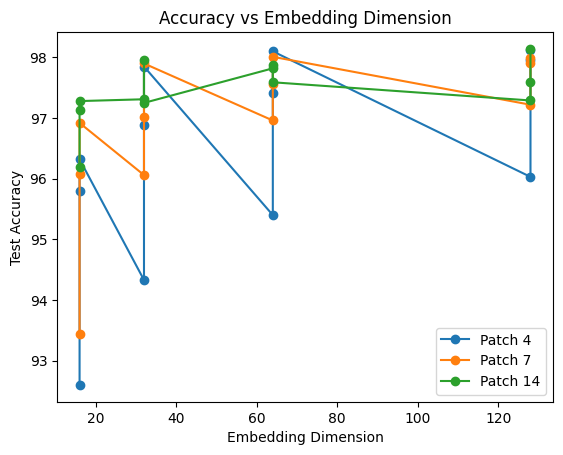

In [ ]:
plt.figure()
for patch_size in patch_sizes:
    subset = df[df['patch_size'] == patch_size]
    plt.plot(subset['embed_dim'], subset['test_acc'], marker='o', label=f'Patch {patch_size}')
plt.xlabel('Embedding Dimension')
plt.ylabel('Test Accuracy')
plt.title('Accuracy vs Embedding Dimension')
plt.legend()
plt.show()


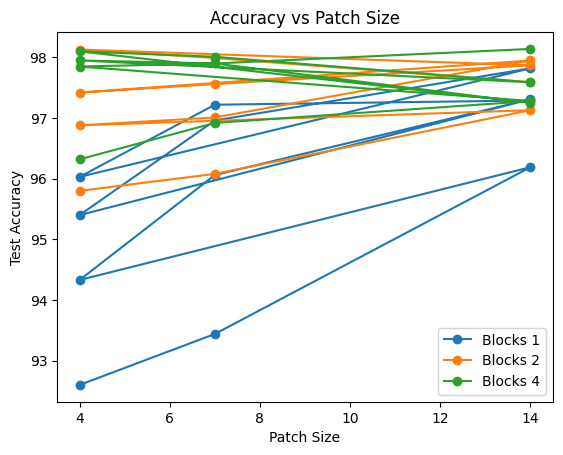

In [ ]:
plt.figure()
for nb_blocks in nb_blocks_list:
    subset = df[df['nb_blocks'] == nb_blocks]
    plt.plot(subset['patch_size'], subset['test_acc'], marker='o', label=f'Blocks {nb_blocks}')
plt.xlabel('Patch Size')
plt.ylabel('Test Accuracy')
plt.title('Accuracy vs Patch Size')
plt.legend()
plt.show()


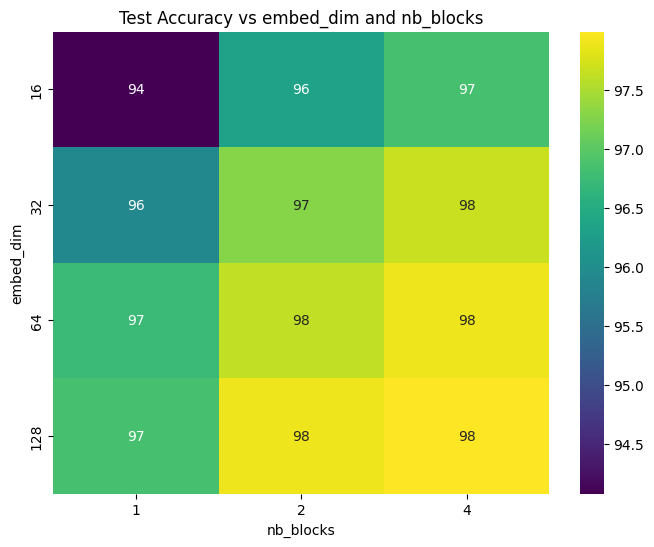

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,6))
pivot = df.pivot_table(index='embed_dim', columns='nb_blocks', values='test_acc')
sns.heatmap(pivot, annot=True, cmap="viridis")
plt.title('Test Accuracy vs embed_dim and nb_blocks')
plt.show()


- From theses different plots, we can see that in most cases, having more blocks improve test accuracy, as well as embedding dimension and patch size, but this comes with a bigger complexity and training time. This more complex configuration in a more general case would require a bigger amount of data to avoid overfitting.

## **Model Complexity**

The **number of tokens** \( N \) processed by the Vision Transformer is given by:

$
N = \frac{H \times W}{\text{patch_size}^2}
$

where \( H \) and \( W \) are the height and width of the input image, and `patch_size` is the size of each image patch.

---

### **Transformer Block Complexity**

Each Transformer block (with self-attention) has a computational complexity of:

$
O(N^2 \cdot d)
$

where:
- \( N \) = number of tokens,
- \( d \) = embedding dimension (`embed_dim`).

The total complexity across all blocks is therefore:

$
O(nb\_blocks \times N^2 \times d)
$

---

### **How to Improve Efficiency**

We can reduce for example computational cost and memory usage by:

1. **Increasing patch size** → decreases \( N \) quadratically.
4. **Reducing the embedding dimension** for smaller, faster models.
5. **Sharing weights** or using **bottleneck layers** to reduce parameter count.

---

### **Summary**

| Parameter      | Effect on Complexity             | Trade-off                     |
|----------------|----------------------------------|-------------------------------|
| `patch_size`   | ↓ Larger → Fewer tokens          | ↓ Detail captured             |
| `embed_dim`    | ↑ Larger → More computation      | ↑ Representation power        |
| `nb_blocks`    | ↑ More → Higher capacity         | ↑ Training time & overfitting |
| `N` (tokens)   | Quadratic impact on computation  | Key factor in ViT scalability |


# Q8: larger transformers

Try to use bigger transformer, for example the ViT-S from the timm library. Test with and without intialization from imagenet.

In [ ]:
!pip install timm

a) Load the model using the timm library without pretrained weights. Try to apply it directly on a tensor with the same MNIST images resolution. What it is the problem and why we have it? Explain if we have also such problem with CNNs. As ViT takes RGB images, the input tensor should have 3 channels.

In [ ]:
import timm
for m in timm.list_models('vit_*'):
    print(m)

vit_7b_patch16_dinov3
vit_base_mci_224
vit_base_patch8_224
vit_base_patch14_dinov2
vit_base_patch14_reg4_dinov2
vit_base_patch16_18x2_224
vit_base_patch16_224
vit_base_patch16_224_miil
vit_base_patch16_384
vit_base_patch16_clip_224
vit_base_patch16_clip_384
vit_base_patch16_clip_quickgelu_224
vit_base_patch16_dinov3
vit_base_patch16_dinov3_qkvb
vit_base_patch16_gap_224
vit_base_patch16_plus_240
vit_base_patch16_plus_clip_240
vit_base_patch16_reg4_gap_256
vit_base_patch16_rope_224
vit_base_patch16_rope_ape_224
vit_base_patch16_rope_mixed_224
vit_base_patch16_rope_mixed_ape_224
vit_base_patch16_rope_reg1_gap_256
vit_base_patch16_rpn_224
vit_base_patch16_siglip_224
vit_base_patch16_siglip_256
vit_base_patch16_siglip_384
vit_base_patch16_siglip_512
vit_base_patch16_siglip_gap_224
vit_base_patch16_siglip_gap_256
vit_base_patch16_siglip_gap_384
vit_base_patch16_siglip_gap_512
vit_base_patch16_xp_224
vit_base_patch32_224
vit_base_patch32_384
vit_base_patch32_clip_224
vit_base_patch32_clip_256

In [ ]:
import timm

# List all model names
all_models = timm.list_models()

# Filter for those containing "vit"
vit_models = [m for m in all_models if "vit_base" in m]
print(len(vit_models), vit_models[:40])

64 ['convit_base', 'crossvit_base_240', 'davit_base', 'davit_base_fl', 'flexivit_base', 'gcvit_base', 'maxvit_base_tf_224', 'maxvit_base_tf_384', 'maxvit_base_tf_512', 'naflexvit_base_patch16_gap', 'naflexvit_base_patch16_map', 'naflexvit_base_patch16_par_gap', 'naflexvit_base_patch16_parfac_gap', 'naflexvit_base_patch16_siglip', 'nextvit_base', 'samvit_base_patch16', 'samvit_base_patch16_224', 'vit_base_mci_224', 'vit_base_patch8_224', 'vit_base_patch14_dinov2', 'vit_base_patch14_reg4_dinov2', 'vit_base_patch16_18x2_224', 'vit_base_patch16_224', 'vit_base_patch16_224_miil', 'vit_base_patch16_384', 'vit_base_patch16_clip_224', 'vit_base_patch16_clip_384', 'vit_base_patch16_clip_quickgelu_224', 'vit_base_patch16_dinov3', 'vit_base_patch16_dinov3_qkvb', 'vit_base_patch16_gap_224', 'vit_base_patch16_plus_240', 'vit_base_patch16_plus_clip_240', 'vit_base_patch16_reg4_gap_256', 'vit_base_patch16_rope_224', 'vit_base_patch16_rope_ape_224', 'vit_base_patch16_rope_mixed_224', 'vit_base_patch16

In [ ]:
model_name = "vit_small_patch16_224"
model = timm.create_model(model_name, pretrained=False)

We'll have a shape mismatch, because it expects a (224x224) shape, while MNIST has a (28x28) shape. Moreover, it expects a 3 channels input, while we have a gray scale image. More precisely:

*   The number of patches extracted by ViT depends on the image size and patch size.
*   ViT creates num_patches = $(H / patch\_size) × (W / patch\_size)$.
*   For 224×224 → 14×14 = 196 tokens.
*   For 28×28 → 1×1 = 1 token.
*   The positional embeddings are fixed to 196 tokens (for 224×224 images).
→ So, mismatch between expected (196) and actual (1).
*  That's why we need to adapt the input to fit to that transformer.


CNNs, on the other hand, don’t have this issue because:

- Convolution and pooling operations are translation-invariant and fully convolutional.

- CNNs can handle any image size (within reason), since they don’t depend on a fixed positional embedding vector.

In [ ]:
import torch.nn.functional as F

x = torch.randn(32, 1, 28, 28)
x = x.repeat(1, 3, 1, 1) # adapt number of channels to fit in ViT
x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
print(x.shape)
model(x).shape

torch.Size([32, 3, 224, 224])


torch.Size([32, 1000])

b) There is a trick in timm that allows to use pretrained models with different image resolution and number of classes. Try to reload the model to be able to use on MNIST images:

In [ ]:
model = timm.create_model(model_name, pretrained=False, num_classes=10, dynamic_img_size=True, patch_size=4)
print(model.dynamic_img_size)
model(torch.randn(32, 3, 28, 28)).shape

True


torch.Size([32, 10])

c) redo the training with the pretrained ViT-S





In [ ]:
@torch.no_grad()
def eval_model(model, loader, device, num_channels=1):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.to(device), y.to(device)
    x = x.repeat(1, 3, 1, 1) # adapt number of channels to fit in ViT

    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

In [ ]:
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# model.cuda()
model = model.to(device)
model.train()

epochs = 10

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    # x, y = x.cuda(), y.cuda()
    x, y = x.to(device), y.to(device)

    opt.zero_grad()
    x = x.repeat(1, 3, 1, 1) # adapt number of channels to fit in ViT
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")

acc = eval_model(model, test_loader, device, num_channels=3)
print(f"Test accuracy: {acc}")

cuda
--- Epoch 0 ---
Train loss: 1.740547028685938
--- Epoch 1 ---
Train loss: 1.289812481606693
--- Epoch 2 ---
Train loss: 1.0818606076210038
--- Epoch 3 ---
Train loss: 1.1069417177741208
--- Epoch 4 ---
Train loss: 1.0125022810151074
--- Epoch 5 ---
Train loss: 0.915961163257485
--- Epoch 6 ---
Train loss: 0.8725943154871845
--- Epoch 7 ---
Train loss: 0.7927863240750359
--- Epoch 8 ---
Train loss: 0.6672129866156751
--- Epoch 9 ---
Train loss: 0.670667600402954
Test accuracy: 79.75


c) redo the training but with the ViT-S pretrained on ImageNet

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "vit_small_patch16_224"
model = timm.create_model(model_name, pretrained=True, num_classes=10, dynamic_img_size=True, patch_size=4).to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

In [ ]:
import timm

epochs = 10

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    # x, y = x.cuda(), y.cuda()
    x, y = x.to(device), y.to(device)

    opt.zero_grad()
    x = x.repeat(1, 3, 1, 1) # adapt number of channels to fit in ViT
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc = eval_model(model, test_loader, device, num_channels=3)
print(f"Test accuracy: {acc}")

--- Epoch 0 ---
Train loss: 0.696638218955254
--- Epoch 1 ---
Train loss: 0.10997480166349202
--- Epoch 2 ---
Train loss: 0.07795081551430989
--- Epoch 3 ---
Train loss: 0.06906378981885689
--- Epoch 4 ---
Train loss: 0.07505582058146945
--- Epoch 5 ---
Train loss: 0.07320953785840954
--- Epoch 6 ---
Train loss: 0.0668418552043405
--- Epoch 7 ---
Train loss: 0.07340908885351631
--- Epoch 8 ---
Train loss: 0.06687589940368764
--- Epoch 9 ---
Train loss: 0.06256874555499474
Test accuracy: 97.45


d) Comment the final results and provide some ideas on how to make transformer work on small datasets. You can take inspiration from some recent work.

When training the Vision Transformer (ViT-S) from scratch on MNIST (i.e. *pretrained=False*), the model achieves **≈79.75%** accuracy on test set with a quite big train loss (0.6706), which is significantly lower than when using the pretrained ImageNet weights (**≈97.45%** with train_loss≈0.0625).

This large gap highlights that ViTs require large-scale data and long training to learn meaningful visual representations. Since MNIST is a small and simple dataset, ViTs tend to underfit or fail to learn robust features when trained from scratch — their data-hungry nature contrasts with CNNs, which generalize better with limited data.

By contrast, initializing the model with pretrained ImageNet weights provides a strong feature extractor already trained on millions of diverse images. Fine-tuning it on MNIST simply adapts these general features to digit recognition.
This process — **transfer learning** — dramatically improves both convergence speed and final performance.

### **How to make Transformers work better on small datasets**

Several approaches have been proposed in recent research to make ViTs more data-efficient and stable when training on limited data:

#### 1. **Data Augmentation**
We can use strong and diverse transformations to artificially increase the effective training set size as we did with the CNNs lab:
- Random crops, flips, rotations.
- Color jittering...  
These techniques improve robustness and invariance.

#### 2. **Regularization and Normalization**
We can try to reduce overfitting and stabilize training:
- With **Dropout**, **BatchNorm** or **LayerNorm**.
- Use **Weight Decay (L2 regularization)** and **learning rate schedulers**.
- Tune batch size for better generalization.

#### 3. **Smaller or Hybrid Architectures**
We can adopt more efficient or inductive-bias–aware designs:
- **DeiT (Data-efficient Image Transformers)** introduces distillation from a CNN teacher and aggressive augmentations  
- **Hybrid ViT** architectures (e.g., `vit_small_r26_s32_224`) combine CNN feature extractors with transformer layers  
- Lightweight models like **ViT-Tiny**, **MobileViT**, or **CvT (Convolutional Vision Transformers)** reduce parameter count and overfitting

#### 4. **Token Reduction / Efficient Attention**
Reducing computational complexity and memory usage:
- Use **patch merging** or **hierarchical attention** (as in Swin Transformer)
- Apply **sparse** or **low-rank attention** approximations

#### 5. **Pretraining and Fine-tuning**
The most effective strategy remains **pretraining on large datasets** (e.g., ImageNet, JFT-300M), then fine-tuning on the target dataset as we did in this lab.  
Even if the pretraining domain is different, transformers adapt remarkably well — as demonstrated in this experiment.

---

### **Summary of Results**

| Setting | Accuracy | Observation |
|----------|-----------|-------------|
| ViT-S, no pretraining | 79.75% | Struggles to learn from small dataset, underfits |
| ViT-S pretrained on ImageNet | 97.45% | Excellent performance through transfer learning |

---

### **References**

- **Dosovitskiy et al.**, *“An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale”*, ICLR 2021.  
- **Touvron et al.**, *“Training data-efficient image transformers & distillation through attention” (DeiT)*, ICML 2021.  
- **Wu et al.**, *“CvT: Introducing Convolutions to Vision Transformers”*, ICCV 2021.  
- **Liu et al.**, *“Swin Transformer: Hierarchical Vision Transformer using Shifted Windows”*, ICCV 2021.  
- **Howard et al.**, *“MobileViT: Light-weight, General-purpose, and Mobile-friendly Vision Transformer”*, ICLR 2022.

---

**Conclusion:**  
Transformers need either *large datasets* or *strong inductive biases*. For small datasets like MNIST, combining **transfer learning**, **data augmentation**, and **efficient architectures** provides the best trade-off between performance and complexity.